# Environmental Sound Classification Using Local Binary Pattern and Audio Features Collaboration

[Ohini Kafui Toffa](mailto:ohini.kafui.toffa@umontreal.ca), Université de Montréal 
[Max Mignotte](mailto:mignotte@iro.umontreal.ca), Université de Montréal  

---

## Introduction

This is the source code of an IEEE Transactions on Multimedia https://ieeexplore.ieee.org/document/9248620 .
The goal is to adapt Local Binary Pattern and Local Phase Quantization to audio signal


## Depencies

This notebook requires some libraries and tools to be installed

    pip3 install librosa pydub openpyxl matplotlib seaborn 
    pip install git+https://github.com/detly/gammatone.git
 

## Dataset
For experiments we used ESC-10, ESC-50(https://github.com/karoldvl/ESC-50) datasets publicly avalaible under [Creative Commons Attribution Non-Commercial license](http://creativecommons.org/licenses/by-nc/3.0/). 
The *ESC-10* dataset consists of 10 categories of recordings (400 clips).
ESC-50 has 50 classes (2 000 clips) in 5 thematic groups. Length of the audio is 5s and the sample is 44100.
We grabbed and updated the original code of the author to load and analyse the dataset. See author article bellow

 [K. J. Piczak. ESC: Dataset for Environmental Sound Classification. In Proceedings of the 23rd ACM international conference on Multimedia, pp. 1015-1018, ACM, 2015](http://dx.doi.org/10.1145/2733373.2806390). 
 The UrbanSound8k dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes. See following article for more information: J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.



Load the dataset audio files list

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
records = pd.read_csv("ESC-50/esc50.csv") 
"""display header and first 5 rows"""
records.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Features Extraction

### Image Descriptors
Local Binary Pattern(LBP1D) and Local Phase Quantization(LPQ1D) on the 1D signal, Local Binary Pattern(LBP), Extended LBP(ELBP), Var LBP(VarLBP) on the Mel Spectogram, Zero Crossing Rate(ZCR), Short Time Frequency Energy(STE)

### Audio descriptors
Mel Frequency Cepstral Coefficient (MFCC), Constant Q-Transform (CQT), the Gammatone Frequency Cepstral Coefficients (GFCC), the Chromagram

In [7]:
import sys
import numpy as np
import pydub
import librosa
import math
#import sys
import gammatone.gtgram
    
class Clip:    
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 2048    # nfft or frame size. We used wideband(see benefit of wideband in https://arxiv.org/pdf/1706.07156.pdf) 
    HOP_LENGTH = 1024 # Hop Length, half of the frame
    LBP_DIGITS = 4 # LBP-1D number of digits
    
    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path, duration):
            self.path = path
            self.duration = duration
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly duration seconds
            self.data = pydub.AudioSegment.silent(duration=self.duration)
            self.data = self.data.overlay((pydub.AudioSegment.from_file(self.path).set_frame_rate(Clip.RATE).set_channels(1))[0:self.duration])
            self.raw = (np.frombuffer(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)   # convert to float  
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print (exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    # extract: 0 if raw value, 1 if histogram, 2 if both
    # test64: use 64bits for LBP1D and LPQ1D
    def __init__(self, filename, fold, target, category, duration=5000, lpq1d=True, lbp1d=True, lbp=True, elbp=True, 
                 var=True, ste=True, zcr=True, mfcc=True, gfcc = True, cqt = True, chroma=True, test64=False, 
                 extract=0, delAudio=True):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.fold = fold
        self.target = target
        self.category = category 
        self.loaded = False
         
        try: 
            self.audio = Clip.Audio(self.path, duration)
            with self.audio as audio:
                if ste or chroma:
                    S = np.abs(librosa.stft(y=audio.raw, n_fft=Clip.FRAME, hop_length=Clip.HOP_LENGTH))
                # compute the Mel spectogram and the MFCC
                self._compute_mel_mfcc(audio, mfcc)
                # apply LBP to the mel spectogram
                if lbp:
                    self._compute_lbp(audio, extract)         
                # apply LPQ to the 1D signal in time space
                if lpq1d:
                    self._compute_lpq1d(audio, test64)
                # apply LBP to the 1D signal in time space
                if lbp1d:
                    self._compute_lbp1d(audio, test64)
                if elbp:
                    # apply ELBP to the mel spectogram
                    self._compute_elbp(audio, extract)
                if var:
                    # apply VAR to the mel spectogram
                    self._compute_var(audio, extract)
                if ste:
                    # apply STE to the mel spectogram 
                    self._compute_ste(S)
                if zcr:
                    # apply ZCR to the mel spectogram             
                    self._compute_zcr(audio)
                if gfcc:
                    # Compute the Gammatone Frequency Cepstral Coefficient          
                    self._compute_gfcc(audio)            
                if cqt:
                    # Compute the constant-Q power spectrum
                    self._compute_cqt(audio)
                if chroma:
                    # Compute a chromagram from power spectrum
                    self._compute_chroma(S)
            if delAudio:
                del self.audio
            self.loaded = True
        except Exception as ex:
            print('Fail to load audio {0}.'.format(self.path))
            print(ex)
                
    def __exit__(self, exception_type, exception_value, traceback):
        if exception_type is not None:
            print (exception_type, exception_value, traceback)
        del self.audio
        del self.melspectrogram
        del self.mfcc 
        del self.cqt
        del self.chroma 
        del self.lpq1d_256
        del self.lbp1d_256 
        del self.lbp
        del self.elbp
        del self.varlbp
  
    def _compute_mel_mfcc(self, audio, mfcc):
        # Compute Mel Spectogram with 2048 FFT window length, HOP Length 1024, 128 bands
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.raw, n_fft=Clip.FRAME, 
                                                             sr=Clip.RATE, hop_length=Clip.HOP_LENGTH, n_mels=128)
        # Compute MFCC
        logamplitude = librosa.amplitude_to_db(self.melspectrogram)
        if mfcc:
            self.mfcc = librosa.feature.mfcc(S=logamplitude, n_mfcc=128).transpose() 
        self.melspectrogram = self.melspectrogram.transpose()    
        
    def _compute_cqt(self, audio):
        # Compute constant-Q power spectrum with HOP Length 1024 and 128 bands
        C = librosa.cqt(y=audio.raw,sr=Clip.RATE, hop_length=Clip.HOP_LENGTH, n_bins=128, bins_per_octave=128)
        self.cqt = librosa.amplitude_to_db(np.abs(C), ref=np.max).transpose() 
        
    def _compute_chroma(self, spectre):
        # Compute a chromagram from power spectrogram with HOP Length 1024 and 128 bands
        c = librosa.feature.chroma_stft(S=spectre,n_fft=Clip.FRAME,sr=Clip.RATE, hop_length=Clip.HOP_LENGTH, n_chroma=128)
        self.chroma = c.transpose() 
        
    def _compute_gfcc(self, audio):
        # Compute a gammatone filter bank from signal with HOP Length 1024 and 128 bands
        c = gammatone.gtgram.gtgram(audio.raw, fs=Clip.RATE, window_time=Clip.FRAME/Clip.RATE, 
                                    hop_time=Clip.HOP_LENGTH/Clip.RATE, channels=128, f_min=0)
        nframes = int(np.ceil((len(audio.data) / 1000.0 * Clip.RATE)/ Clip.HOP_LENGTH))
        if c.shape[1] < nframes:# pad first and last column
            c = np.insert(c, 0, 0, axis=1)
            c = np.insert(c, nframes-1, 0, axis=1)
        self.gfcc = c.transpose()
            
    def _compute_lpq1d(self, audio, test64):
            # LPQ 1D
            self.lpq1d_64 = []
            self.lpq1d_256 = []
            szWind = 9
            midSzWind = int((szWind-1) / 2)
            lgth = len(audio.data)
            histoBin64 = 64
            histoBin256 = 256
            frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.HOP_LENGTH))
            for f in range(0, frames):
                frame = Clip._get_frame(audio, f)            
                frLgth = len(frame) 
                histo64 = []
                histo256 = []
                squWinTotal = []
                if test64:
                    for j in range(histoBin64):
                        histo64.append(0)
                for j in range(histoBin256):
                    histo256.append(0)                 
                # Compute LPQ for each point
                for i in range(midSzWind, frLgth-midSzWind):
                    # Compute Square window
                    squWin = [] 
                    # Intialize array                            
                    for j in range(szWind):
                        squWin.append(0)
                    for k in range(szWind):
                        pos=i-midSzWind+k;
                        squWin[k]=frame[pos]
                    # Add gaussian noise
                    for k in range(szWind):
                        squWin[k]*=Clip._funcgauss1D(abs(k-midSzWind),1.0*szWind)
                    #np.append(squWinTotal, squWin)
                    squWinTotal.append(squWin)
                squWinTotal = np.asarray(squWinTotal)
                #print(np.shape(squWinTotal))
                squWinTotalRavel = squWinTotal.ravel()
                # Short FFT computation with midSzWind window length, szWind hop length
                audioFFT = librosa.stft(squWinTotalRavel, n_fft=szWind, hop_length=szWind)
                audioShape = np.shape(audioFFT)
                #print(audioShape)# should be (midSzWind,frLgth-szWind)
                for i in range(0, audioShape[1]):
                    code = 0
                    real = audioFFT[midSzWind,i].real
                    imag = audioFFT[midSzWind,i].imag
                    code = code + Clip._sign_LPQ(real, imag)*pow(4,0)

                    real = audioFFT[midSzWind-1,i].real
                    imag = audioFFT[midSzWind-1,i].imag
                    code = code + Clip._sign_LPQ(real, imag)*pow(4,1)
                    
                    real = audioFFT[midSzWind-2,i].real
                    imag = audioFFT[midSzWind-2,i].imag
                    code = code + Clip._sign_LPQ(real, imag)*pow(4,2)
                    
                    if test64:
                        histo64[code] = histo64[code] + 1
                    
                    real = audioFFT[midSzWind-3,i].real
                    imag = audioFFT[midSzWind-3,i].imag
                    code = code + Clip._sign_LPQ(real, imag)*pow(4,3)                    
                    
                    histo256[code] = histo256[code] + 1
                if test64:
                    self.lpq1d_64.append(histo64)
                self.lpq1d_256.append(histo256)
            if test64:
                self.lpq1d_64 = np.asarray(self.lpq1d_64)  
            self.lpq1d_256 = np.asarray(self.lpq1d_256)
            
    def _compute_lbp1d(self, audio, test64):
        # LBP-1D
        self.lbp1d_64 = []
        self.lbp1d_256 = []
        r = 4 # radius 4 and points 8
        frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.HOP_LENGTH))
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            histoBin64 = 64
            histoBin256 = 256
            histo64 = []
            histo256 = []
            if test64:
                for j in range(histoBin64):
                    histo64.append(0)
            for j in range(histoBin256):
                histo256.append(0)                
            frLgth = len(frame)
            for j in range(r, frLgth-r):
                code = 0
                x = frame[j]
                code = code + Clip._sign_LBP(frame[j+1] - x)*pow(2,0)
                code = code + Clip._sign_LBP(frame[j-1] - x)*pow(2,1)
                code = code + Clip._sign_LBP(frame[j+2] - x)*pow(2,2)
                code = code + Clip._sign_LBP(frame[j-2] - x)*pow(2,3)
                code = code + Clip._sign_LBP(frame[j+3] - x)*pow(2,4)
                code = code + Clip._sign_LBP(frame[j-3] - x)*pow(2,5)                
                if test64:
                    histo64[code] = histo64[code] + 1
                
                code = code + Clip._sign_LBP(frame[j+4] - x)*pow(2,6)
                code = code + Clip._sign_LBP(frame[j-4] - x)*pow(2,7)                
                histo256[code] = histo256[code] + 1
            if test64:
                self.lbp1d_64.append(histo64)
            self.lbp1d_256.append(histo256)
        if test64:
            self.lbp1d_64 = np.asarray(self.lbp1d_64)
        self.lbp1d_256 = np.asarray(self.lbp1d_256)
            
    def _compute_lbp(self, audio, extract):
        self.lbp = [] # Histogram of the LBP
        self.lbpRaw = [] # Raw value of the LBP
        melShape = self.melspectrogram.shape
        histoBin = 256
        if extract == 0:
            self.lbpRaw = np.zeros(melShape)
        elif extract == 1:
            self.lbp = np.zeros((melShape[0], histoBin))
        else:
            self.lbpRaw = np.zeros(melShape)
            self.lbp = np.zeros((melShape[0], histoBin))
        for i in range(1,melShape[0]-1):           
            for j in range(1,melShape[1]-1):
                code = 0
                x = self.melspectrogram[i][j]
                code = code + Clip._sign_LBP(self.melspectrogram[i-1][j+1] - x)*pow(2,0)
                code = code + Clip._sign_LBP(self.melspectrogram[i][j+1] - x)*pow(2,1)
                code = code + Clip._sign_LBP(self.melspectrogram[i+1][j+1] - x)*pow(2,2)
                code = code + Clip._sign_LBP(self.melspectrogram[i+1][j] - x)*pow(2,3)
                code = code + Clip._sign_LBP(self.melspectrogram[i+1][j-1] - x)*pow(2,4)
                code = code + Clip._sign_LBP(self.melspectrogram[i][j-1] - x)*pow(2,5)
                code = code + Clip._sign_LBP(self.melspectrogram[i-1][j-1] - x)*pow(2,6)
                code = code + Clip._sign_LBP(self.melspectrogram[i-1][j] - x)*pow(2,7)
                if extract > 0:
                    self.lbp[i][code] = self.lbp[i][code] + 1
                if extract == 0 or extract == 2:
                    self.lbpRaw[i][j] = code 
        
    def _compute_elbp(self, audio, extract):
        self.elbp = [] # Histogram of the LBP
        self.elbpRaw = [] # Raw value of the LBP        
        melShape = self.melspectrogram.shape
        radius = 1
        neighbors = 8
        rows = int(melShape[0])
        cols = int(melShape[1])
        histo = [] # Histogram of ELBP
        rawVal = np.zeros((rows, cols))  # ELBP raw value             
        for n in range(neighbors):
            # sample points
            x = radius*math.cos(2.0*math.pi*n/neighbors)
            y = -radius*math.sin(2.0*math.pi*n/neighbors)      
            # relative indices
            fx = int(np.floor(x))
            fy = int(np.floor(y))
            cx = int(np.ceil(x))
            cy = int(np.ceil(y))        
            # fractional part
            ty = y - fy
            tx = x - fx  
            # set interpolation weights
            w1 = (1 - tx) * (1 - ty)
            w2 = tx * (1 - ty)
            w3 = (1 - tx) * ty
            w4 = tx * ty
            # iterate through your data
            for i in range(radius, rows-radius):
                for j in range(radius, cols-radius):
                    t1 = w1*self.melspectrogram[i+fy][j+fx] + w2*self.melspectrogram[i+fy][j+cx] 
                    t2 = w3*self.melspectrogram[i+cy][j+fx] + w4*self.melspectrogram[i+cy][j+cx]
                    t = t1 + t2
                    rawVal[i-radius][j-radius] += (((t > self.melspectrogram[i][j]) and (abs(t-self.melspectrogram[i][j]) > sys.float_info.epsilon)) << n)           
        rawVal, histo = Clip._limit_and_histo(rawVal)
        if extract == 0:
            self.elbpRaw = rawVal
        elif extract == 1:
            self.elbp = histo
        else:
            self.elbpRaw = rawVal
            self.elbp = histo
        
    def _compute_var(self, audio, extract):
        melShape = self.melspectrogram.shape
        radius = 1
        neighbors = 8
        rows = int(melShape[0])
        cols = int(melShape[1])
        self.varlbpRaw = [] # Raw value of the LBP
        self.varlbp = [] # Histogram of VARLBP
        rawVal = np.zeros((rows, cols))  # VARLBP raw value 
        _mean = np.zeros(melShape)
        _delta = np.zeros(melShape)
        _m2 = np.zeros(melShape)
        for n in range(neighbors):
            # sample points
            x = radius*math.cos(2.0*math.pi*n/neighbors)
            y = -radius*math.sin(2.0*math.pi*n/neighbors)      
            # relative indices
            fx = int(np.floor(x))
            fy = int(np.floor(y))
            cx = int(np.ceil(x))
            cy = int(np.ceil(y))        
            # fractional part
            ty = y - fy
            tx = x - fx  
            # set interpolation weights
            w1 = (1 - tx) * (1 - ty)
            w2 = tx * (1 - ty)
            w3 = (1 - tx) * ty
            w4 = tx * ty
            # iterate through your data
            for i in range(radius, rows-radius):
                for j in range(radius, cols-radius):
                    t1 = w1*self.melspectrogram[i+fy][j+fx] + w2*self.melspectrogram[i+fy][j+cx] 
                    t2 = w3*self.melspectrogram[i+cy][j+fx] + w4*self.melspectrogram[i+cy][j+cx]
                    t = t1 + t2
                    _delta[i][j] = t - _mean[i][j]
                    _mean[i][j] = _mean[i][j] + (_delta[i][j] / (1.0*(n+1)))
                    _m2[i][j] = _m2[i][j] + _delta[i][j] * (t - _mean[i][j])
        # calculate result
        for i in range(radius, rows-radius):
            for j in range(radius, cols-radius):
                rawVal[i-radius][j-radius] = _m2[i][j] / (1.0*(neighbors-1))
        rawVal, histo = Clip._limit_and_histo(rawVal)
        if extract == 0:
            self.varRaw = rawVal
        elif extract == 1:
            self.var = histo
        else:
            self.varRaw = rawVal
            self.var = histo        

    def _compute_ste(self, spectre):
        # Short Time Energy
        self.ste = librosa.feature.rms(S=spectre) 
        self.ste = self.ste.ravel()
            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil((len(audio.data) / 1000.0 * Clip.RATE)/ Clip.HOP_LENGTH))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))
        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.HOP_LENGTH):(index* Clip.HOP_LENGTH + Clip.FRAME)]
    
    @classmethod
    def _sign_LPQ(cls, re, im):
        ret = 0
        if re > 0:
            ret = ret + 1
        if im > 0:
            ret = ret + 2
        return  ret
    
    @classmethod
    def _sign_LBP(cls, x):
        ret = 0
        if x > 0:
            ret = ret + 1
        return  ret    
    
    @classmethod
    def _funcgauss1D(cls, x, var):
        return math.exp(-(x*x)/(2*var))
    
    @classmethod
    def _limit_and_histo(cls, img):
        imgShape = np.shape(img)
        rows = imgShape[0]
        cols = imgShape[1]
        histo = np.zeros((rows, 256))
        for i in range(rows):
            for j in range(cols):
                if img[i][j] < 0:
                    img[i][j] = 0
                elif img[i][j] > 255:
                    img[i][j] = 255
                histo[i][int(img[i][j])] += 1
        return img, histo
        

### Quick view of a dog audio record

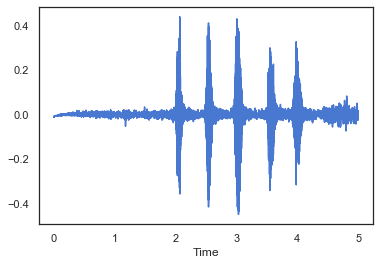

In [8]:
import IPython.display
import os
import glob
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import random
random.seed(20150420)
 
""" Load one item of the dataset: dog sound"""
clip = Clip('ESC-50/1-30226-A-0.wav',1, 0,'dog', test64=True, extract=2, delAudio=False)
#UrbanSound8K/audio/fold5/19007-4-0-0.wav
if clip.loaded:
    with clip.audio as audio:
        #plt.title('{0} : {1}'.format(clip.category, clip.filename))
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Time')
        plt.plot(np.arange(0, len(audio.raw)) / Clip.RATE, audio.raw)

    IPython.display.Audio(filename=clip.path, rate=Clip.RATE)   
else:
    del clip

Mel Spectogram: (216, 128)


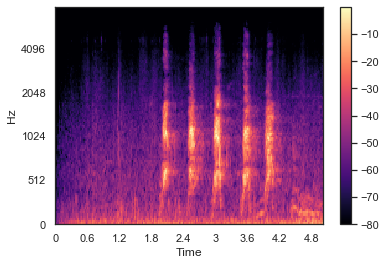

In [5]:
with clip.audio as audio: 
    print('Mel Spectogram:', np.shape(clip.melspectrogram))
    #plt.title('Mel Spectogram')
    librosa.display.specshow(librosa.power_to_db(clip.melspectrogram.transpose(), ref=np.max), y_axis='mel', x_axis='time', fmax=8000)
    plt.colorbar()

MFCC: (216, 128)


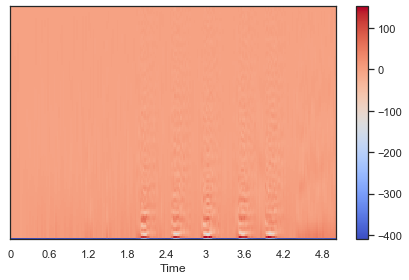

In [6]:
with clip.audio as audio: 
    print('MFCC:', np.shape(clip.mfcc))
    #plt.figure(figsize=(10, 4))
    librosa.display.specshow(clip.mfcc.transpose(), x_axis='time')
    plt.colorbar()
    #plt.title('MFCC')
    plt.tight_layout()
    plt.show()

GFCC: (216, 128)


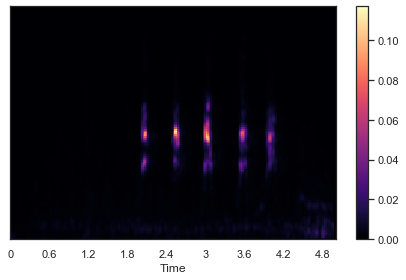

In [7]:
with clip.audio as audio: 
    print('GFCC:', np.shape(clip.gfcc))
    librosa.display.specshow(clip.gfcc.transpose(), x_axis='time')
    plt.colorbar()
    #plt.title('GFCC')
    plt.tight_layout()
    plt.show()

CQT: (216, 128)


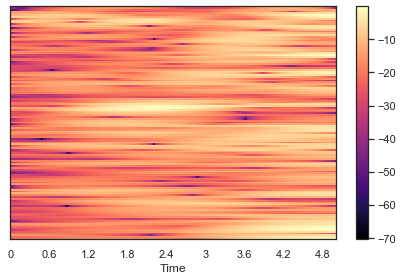

In [8]:
with clip.audio as audio: 
    print('CQT:', np.shape(clip.cqt))
    librosa.display.specshow(clip.cqt.transpose(), x_axis='time')
    plt.colorbar()
    #plt.title('CQT')
    plt.tight_layout()
    plt.show()

Chromagram: (216, 128)


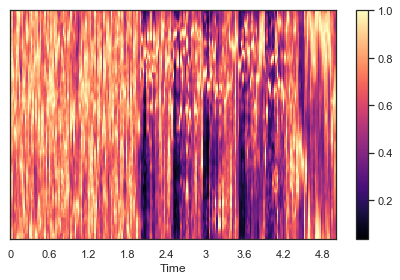

In [9]:
with clip.audio as audio: 
    print('Chromagram:', np.shape(clip.cqt))
    librosa.display.specshow(clip.chroma.transpose(), x_axis='time')
    plt.colorbar()
    #plt.title('Chromagram')
    plt.tight_layout()
    plt.show()

LBP Raw: (216, 128)


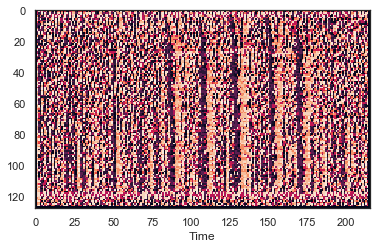

In [10]:
with clip.audio as audio: 
    print('LBP Raw:', np.shape(clip.lbpRaw))
    #plt.title('LBP Raw')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time')    
    plt.imshow(clip.lbpRaw.transpose())   

LBP: (216, 256)


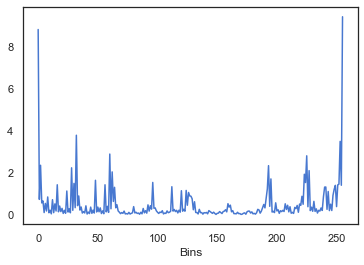

In [11]:
with clip.audio as audio: 
    print('LBP:', np.shape(clip.lbp))
    #plt.title('LBP')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Bins')    
    lbpView = np.mean(clip.lbp[:, :], axis=0)[0:] #clip.lbp.ravel()
    plt.plot(np.arange(0, len(lbpView)), lbpView)  

ELBP Raw: (216, 128)


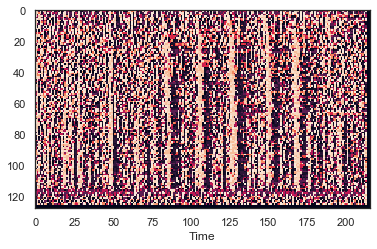

In [12]:
with clip.audio as audio:    
    print('ELBP Raw:', np.shape(clip.elbpRaw))
    #plt.title('ELBP Raw')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time')    
    plt.imshow(clip.elbpRaw.transpose())      

LBP: (216, 256)


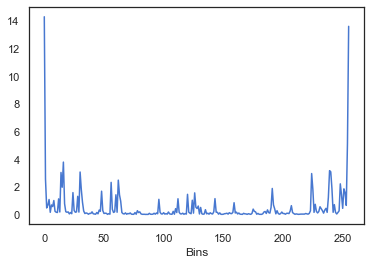

In [13]:
with clip.audio as audio:    
    print('LBP:', np.shape(clip.elbp))
    #plt.title('ELBP')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Bins')    
    elbpView = np.mean(clip.elbp[:, :], axis=0)[0:]
    plt.plot(np.arange(0, len(elbpView)), elbpView)       

VAR Raw: (216, 128)


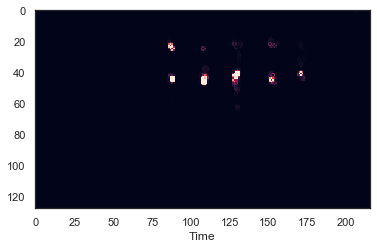

In [14]:
with clip.audio as audio:    
    print('VAR Raw:', np.shape(clip.varRaw))
    #plt.title('VAR Raw')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time')    
    plt.imshow(clip.varRaw.transpose())      

VAR: (216, 256)


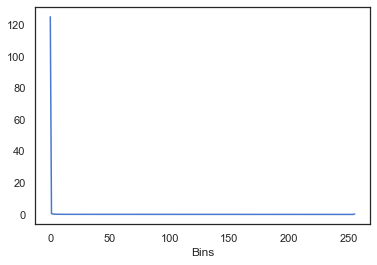

In [15]:
with clip.audio as audio:    
    print('VAR:', np.shape(clip.var))
    #plt.title('VAR')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Bins')    
    varView = np.mean(clip.var[:, :], axis=0)[0:]
    plt.plot(np.arange(0, len(varView)), varView)       

LBP1D 64: (216, 64)


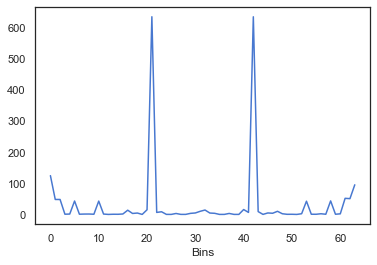

In [16]:
with clip.audio as audio:    
    print('LBP1D 64:', np.shape(clip.lbp1d_64))
    #plt.title('LBP1D 64')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Bins')    
    lbp1dView = np.mean(clip.lbp1d_64[:, :], axis=0)[0:]
    plt.plot(np.arange(0, len(lbp1dView)), lbp1dView) 

LBP1D 256: (216, 256)


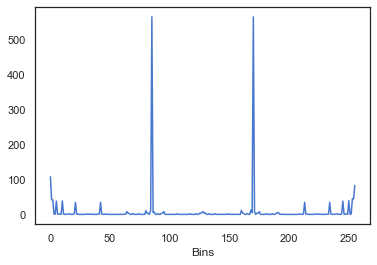

In [17]:
with clip.audio as audio:    
    print('LBP1D 256:', np.shape(clip.lbp1d_256))
    #plt.title('LBP1D 256')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Bins')    
    lbp1dView = np.mean(clip.lbp1d_256[:, :], axis=0)[0:]
    plt.plot(np.arange(0, len(lbp1dView)), lbp1dView)    

LPQ1D 64: (216, 64)


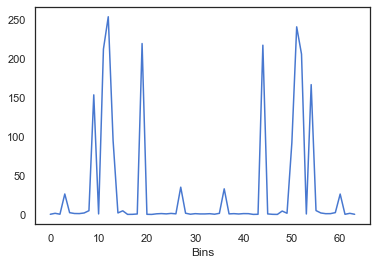

In [18]:
with clip.audio as audio:    
    print('LPQ1D 64:', np.shape(clip.lpq1d_64))
    #plt.title('LPQ1D 64')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Bins')    
    lbp1d64View = np.mean(clip.lpq1d_64[:, :], axis=0)[0:]
    plt.plot(np.arange(0, len(lbp1d64View)), lbp1d64View)     

LPQ1D 256: (216, 256)


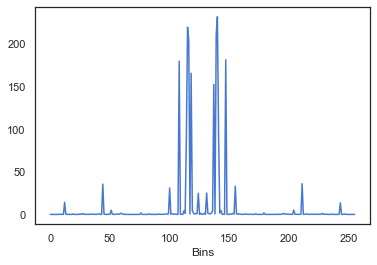

In [19]:
with clip.audio as audio:    
    print('LPQ1D 256:', np.shape(clip.lpq1d_256))
    #plt.title('LPQ1D 256')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Bins')    
    lbp1d256View = np.mean(clip.lpq1d_256[:, :], axis=0)[0:]
    plt.plot(np.arange(0, len(lbp1d256View)), lbp1d256View)      

STE: (216,)


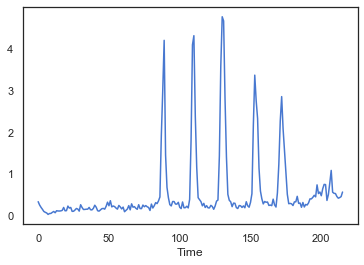

In [20]:
with clip.audio as audio:    
    print('STE:',np.shape(clip.ste))
    #plt.title('STE')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time')    
    steView = clip.ste
    plt.plot(np.arange(0, len(steView)), steView) 

ZCR: (216,)


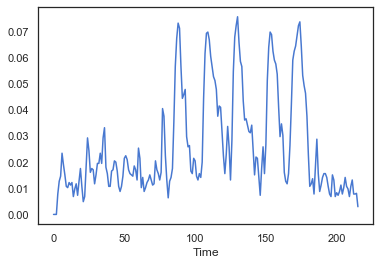

In [21]:
with clip.audio as audio:    
    print('ZCR:',np.shape(clip.zcr))
    #plt.title('ZCR')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time')    
    zcrView = clip.zcr.ravel()
    plt.plot(np.arange(0, len(zcrView)), zcrView)     

## Dataset Load

In [22]:
import os
from collections import defaultdict
def load_dataset(records, dataset='esc10', lpq1d=True, lbp1d=True, lbp=True, elbp=True, var=True, ste=True, zcr=True, 
                 mfcc=True, gfcc=True, cqt = True, chroma=True, test64=False, extract=0, delAudio=True):
    # Convert to dataFrame 
    dataFrame = pd.DataFrame(records)
    """Load all dataset recordings into a nested list."""
    d = defaultdict(list)
    clips = []
    nbClip = 0
    #i = 0
    for index, row in dataFrame.iterrows():
        if dataset=='urbansound8k':
            filename = row['slice_file_name']
            fold = row['fold']
            clip = Clip('UrbanSound8K/audio/fold{}/{}'.format(fold, filename), fold, row['classID'], row['class'], duration=4000,
                        lbp=lbp, lpq1d=lpq1d, lbp1d=lbp1d, elbp=elbp, var=var, ste=ste, zcr=zcr, mfcc=mfcc, 
                        gfcc=gfcc, cqt=cqt, chroma=chroma, test64=test64, extract=extract, delAudio=delAudio)
            if clip.loaded:
                d[int(clip.target)].append(clip)
                nbClip += 1
            else:
                 del clip                
        elif (dataset=='esc50') or (dataset=='esc10' and row['esc10']):
            clip = Clip('ESC-50/{0}'.format(row['filename']), row['fold'], row['target'], row['category'], duration=5000,
                        lbp=lbp, lpq1d=lpq1d, lbp1d=lbp1d, elbp=elbp, var=var, ste=ste, zcr=zcr, mfcc=mfcc, 
                        gfcc=gfcc, cqt=cqt, chroma=chroma, test64=test64, extract=extract, delAudio=delAudio)
            if clip.loaded:
                d[int(clip.target)].append(clip)
                nbClip += 1
            else:
                 del clip   
        if(nbClip>0 and nbClip%100==0):
            print('NbClips loaded:{0}'.format(nbClip))
       
    for key, value in sorted(d.items(), key=lambda item: item[0]):
        categories = [] 
        for j in value:
            categories.append(j)
        #print('{0}/{1}'.format(len(categories),len(clips)))
        clips.append(categories)
    IPython.display.clear_output()
    #print('{0}/{1}'.format(len(clips[0]),len(clips)))
    print('Load of {0} records done. dataset={1}'.format(nbClip,dataset))                
    return clips

## ESC-10
Use ESC-10 for proof of concept

In [23]:
# pickle it
import pickle
clips_10 = load_dataset(records, dataset='esc10', extract=2, test64=True, delAudio=False)

Load of 400 records done. dataset=esc10


NameError: name 'cases' is not defined

In [24]:
pickle_out = open("esc10.pickle","wb")
pickle.dump(clips_10, pickle_out)
pickle_out.close()

### View of LBP feature

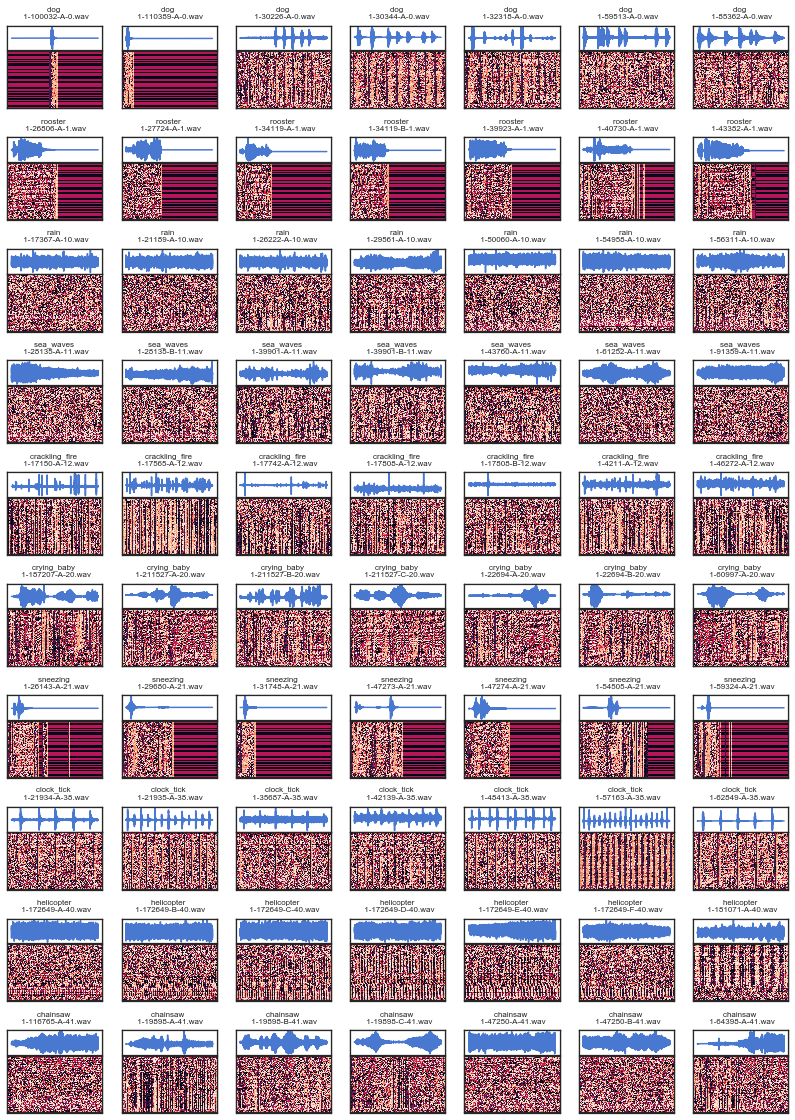

In [25]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], facecolor='w')

def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    #ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    ax_lpq = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)
        
        ax_lpq.imshow(clip.lbpRaw.transpose()) 
        #lpqView = np.mean(clip.lpq[:, :], axis=0)[0:] #clip.lpq.ravel()
        #ax_lpq.plot(np.arange(0, len(lpqView)), lpqView)
        ax_lpq.get_xaxis().set_visible(False)
        ax_lpq.get_yaxis().set_visible(False)        

categories =10 #10
clips_shown = 7 #7
f, axes = plt.subplots(categories, clips_shown, figsize=(clips_shown * 2, categories * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c in range(0, categories):
    for i in range(0, clips_shown):
        plot_clip_overview(clips_10[c][i], axes[c, i])

# Sound classification

## Classification with machine learning techniques

We will begin by using some standard machine learning classifiers on the *ESC-10* dataset. Features (LBP, ELBP, VARLBP, LPQ1D, LBP1D, STE, ZCR, MFCC, GFCC, CQT and Chromagram) will be summarized for each clip (across frames) with their mean and standard deviation.

In [167]:
def create_set(clips, lpq1d=True, lbp1d=True, lbp=True, elbp=True, var=True, ste=True, zcr=True, 
               mfcc=True, gfcc=True, cqt = True, chroma=True, test64=True):
    cases = pd.DataFrame()

    for c in range(0, len(clips)):
        for i in range(0, len(clips[c])):
            case = pd.DataFrame([clips[c][i].filename], columns=['filename'])
            case['category'] = c
            case['category_name'] = clips[c][i].category
            case['fold'] = clips[c][i].fold
            
            if lbp1d and test64:
                lbp1d_64_mean = pd.DataFrame(np.mean(clips[c][i].lbp1d_64[:, :], axis=0)[0:]).T
                lbp1d_64_mean.columns = list('LBP1D_64_{} mean'.format(i) for i in range(np.shape(clips[c][i].lbp1d_64)[1]))[0:]
                lbp1d_64_std = pd.DataFrame(np.std(clips[c][i].lbp1d_64[:, :], axis=0)[0:]).T
                lbp1d_64_std.columns = list('LBP1D_64_{} std dev'.format(i) for i in range(np.shape(clips[c][i].lbp1d_64)[1]))[0:]
                case = case.join(lbp1d_64_mean)
                case = case.join(lbp1d_64_std) 
            
            if lpq1d and test64:
                lpq1d_64_mean = pd.DataFrame(np.mean(clips[c][i].lpq1d_64[:, :], axis=0)[0:]).T
                lpq1d_64_mean.columns = list('LPQ1D_64_{} mean'.format(i) for i in range(np.shape(clips[c][i].lpq1d_64)[1]))[0:]
                lpq1d_64_std = pd.DataFrame(np.std(clips[c][i].lpq1d_64[:, :], axis=0)[0:]).T
                lpq1d_64_std.columns = list('LPQ1D_64_{} std dev'.format(i) for i in range(np.shape(clips[c][i].lpq1d_64)[1]))[0:]
                case = case.join(lpq1d_64_mean)
                case = case.join(lpq1d_64_std)                                                     
                
            if lpq1d:
                lpq1d_256_mean = pd.DataFrame(np.mean(clips[c][i].lpq1d_256[:, :], axis=0)[0:]).T
                lpq1d_256_mean.columns = list('LPQ1D_256_{} mean'.format(i) for i in range(np.shape(clips[c][i].lpq1d_256)[1]))[0:]
                lpq1d_256_std = pd.DataFrame(np.std(clips[c][i].lpq1d_256[:, :], axis=0)[0:]).T
                lpq1d_256_std.columns = list('LPQ1D_256_{} std dev'.format(i) for i in range(np.shape(clips[c][i].lpq1d_256)[1]))[0:]
                case = case.join(lpq1d_256_mean)
                case = case.join(lpq1d_256_std)                
                
            if lbp1d:
                lbp1d_256_mean = pd.DataFrame(np.mean(clips[c][i].lbp1d_256[:, :], axis=0)[0:]).T
                lbp1d_256_mean.columns = list('LBP1D_256_{} mean'.format(i) for i in range(np.shape(clips[c][i].lbp1d_256)[1]))[0:]
                lbp1d_256_std = pd.DataFrame(np.std(clips[c][i].lbp1d_256[:, :], axis=0)[0:]).T
                lbp1d_256_std.columns = list('LBP1D_256_{} std dev'.format(i) for i in range(np.shape(clips[c][i].lbp1d_256)[1]))[0:]
                case = case.join(lbp1d_256_mean)
                case = case.join(lbp1d_256_std)                   
                
            if var:
                var_mean = pd.DataFrame(np.mean(clips[c][i].var[:, :], axis=0)[0:]).T
                var_mean.columns = list('VAR_{} mean'.format(i) for i in range(np.shape(clips[c][i].var)[1]))[0:]
                var_std = pd.DataFrame(np.std(clips[c][i].var[:, :], axis=0)[0:]).T
                var_std.columns = list('VAR_{} std dev'.format(i) for i in range(np.shape(clips[c][i].var)[1]))[0:]
                case = case.join(var_mean)
                case = case.join(var_std) 
                
            if lbp:
                lbp_mean = pd.DataFrame(np.mean(clips[c][i].lbp[:, :], axis=0)[0:]).T
                lbp_mean.columns = list('LBP_{} mean'.format(i) for i in range(np.shape(clips[c][i].lbp)[1]))[0:]
                lbp_std = pd.DataFrame(np.std(clips[c][i].lbp[:, :], axis=0)[0:]).T
                lbp_std.columns = list('LBP_{} std dev'.format(i) for i in range(np.shape(clips[c][i].lbp)[1]))[0:]
                case = case.join(lbp_mean)
                case = case.join(lbp_std)                 
                
            if elbp:
                elbp_mean = pd.DataFrame(np.mean(clips[c][i].elbp[:, :], axis=0)[0:]).T
                elbp_mean.columns = list('ELBP_{} mean'.format(i) for i in range(np.shape(clips[c][i].elbp)[1]))[0:]
                elbp_std = pd.DataFrame(np.std(clips[c][i].elbp[:, :], axis=0)[0:]).T
                elbp_std.columns = list('ELBP_{} std dev'.format(i) for i in range(np.shape(clips[c][i].elbp)[1]))[0:]
                case = case.join(elbp_mean)
                case = case.join(elbp_std)                 
                
            if mfcc:
                mfcc_mean = pd.DataFrame(np.mean(clips[c][i].mfcc[:, :], axis=0)[0:]).T
                mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[0:]
                mfcc_std = pd.DataFrame(np.std(clips[c][i].mfcc[:, :], axis=0)[0:]).T
                mfcc_std.columns = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[0:]
                case = case.join(mfcc_mean)
                case = case.join(mfcc_std)
                
            if gfcc:
                gfcc_mean = pd.DataFrame(np.mean(clips[c][i].gfcc[:, :], axis=0)[0:]).T
                gfcc_mean.columns = list('GFCC_{} mean'.format(i) for i in range(np.shape(clips[c][i].gfcc)[1]))[0:]
                gfcc_std = pd.DataFrame(np.std(clips[c][i].gfcc[:, :], axis=0)[0:]).T
                gfcc_std.columns = list('GFCC_{} std dev'.format(i) for i in range(np.shape(clips[c][i].gfcc)[1]))[0:]
                case = case.join(gfcc_mean)
                case = case.join(gfcc_std) 
                
            if chroma:
                chroma_mean = pd.DataFrame(np.mean(clips[c][i].chroma[:, :], axis=0)[0:]).T
                chroma_mean.columns = list('CHROMA_{} mean'.format(i) for i in range(np.shape(clips[c][i].chroma)[1]))[0:]
                chroma_std = pd.DataFrame(np.std(clips[c][i].chroma[:, :], axis=0)[0:]).T
                chroma_std.columns = list('CHROMA_{} std dev'.format(i) for i in range(np.shape(clips[c][i].chroma)[1]))[0:]
                case = case.join(chroma_mean)
                case = case.join(chroma_std) 
                
            if ste:
                case['STE mean'] = np.mean(clips[c][i].ste)
                case['STE std dev'] = np.std(clips[c][i].ste)                  
                
            if zcr:
                case['ZCR mean'] = np.mean(clips[c][i].zcr)
                case['ZCR std dev'] = np.std(clips[c][i].zcr)   
                
            if cqt:
                cqt_mean = pd.DataFrame(np.mean(clips[c][i].cqt[:, :], axis=0)[0:]).T
                cqt_mean.columns = list('CQT_{} mean'.format(i) for i in range(np.shape(clips[c][i].cqt)[1]))[0:]
                cqt_std = pd.DataFrame(np.std(clips[c][i].cqt[:, :], axis=0)[0:]).T
                cqt_std.columns = list('CQT_{} std dev'.format(i) for i in range(np.shape(clips[c][i].cqt)[1]))[0:]
                case = case.join(cqt_mean)
                case = case.join(cqt_std)                

            cases = cases.append(case)
    
    cases[['category', 'fold']] = cases[['category', 'fold']].astype(int)
    return cases

In [168]:
cases_10 = create_set(clips_10)
cases_10.to_csv('esc10_feat.csv')

In [2]:
#import numpy as np
#import pandas as pd
#cases_10 = pd.read_csv("esc10_feat.csv")

Following Machine Learning classifiers are used: [k-nearest neighbors](http://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [random forest](http://en.wikipedia.org/wiki/Random_forest) and SVM ([support vector machine](http://en.wikipedia.org/wiki/Support_vector_machine)).

Default *scikit-learn* settings will be modified in the following way:
- k-NN with 8 neighbors ([n_neighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)),
- random forest with 500 trees ([n_estimators](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)),
- SVM with linear [kernel](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) and 0.1 penalty.

In [9]:
def to_percentage(number):
    return int(number * 1000) / 10.0

In [10]:
import sklearn as sk
import sklearn.ensemble

def classify(cases, classifier='knn', features_start='LBP_0 mean',features_end = 'LBP_255 std dev', foldNb=5, debug=False):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, foldNb+1):
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        classifier_name = ''
        train_X = train.loc[:, features_start:features_end]
        test_X = test.loc[:, features_start:features_end]
            
        if classifier == 'knn':
            classifier_name = 'k-NN'
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=8)
            knn.fit(train_X, train['category'])
            test.loc[:, 'prediction'] = knn.predict(test_X)
            
        if classifier == 'rf':
            classifier_name = 'Random Forest'
            rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20150420)
            rf.fit(train_X, train['category'])
            test.loc[:, 'prediction'] = rf.predict(test_X)
            
        if classifier == 'svm':
            classifier_name = 'Support Vector Machine (SVM)'
            svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
            svm.fit(train_X, train['category'])
            test.loc[:, 'prediction'] = svm.predict(test_X)

        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        results.append(accuracy)
        confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
        confusion = confusion + confusion_current
        
        print('Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy)))
        if debug:
            print('Confusion matrix:\n', confusion_current, '\n')
        
    print('Average accuracy: {0}%\n'.format(to_percentage(np.mean(results))))
    return confusion, results

### LPQ1D 64 bin

In [171]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_64_0 mean','LPQ1D_64_63 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_64_0 mean','LPQ1D_64_63 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_64_0 mean','LPQ1D_64_63 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 58.7%
Classifying fold 2 with k-NN classifier. Accuracy: 48.7%
Classifying fold 3 with k-NN classifier. Accuracy: 52.5%
Classifying fold 4 with k-NN classifier. Accuracy: 58.7%
Classifying fold 5 with k-NN classifier. Accuracy: 51.2%
Average accuracy: 54.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 70.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 67.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 68.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 70.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 60.0%
Average accuracy: 67.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 62.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 66.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 60.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 65.0%
Classifying

### LBP1D 64 bin

In [172]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LBP1D_64_0 mean','LBP1D_64_63 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LBP1D_64_0 mean','LBP1D_64_63 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LBP1D_64_0 mean','LBP1D_64_63 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 50.0%
Classifying fold 2 with k-NN classifier. Accuracy: 50.0%
Classifying fold 3 with k-NN classifier. Accuracy: 50.0%
Classifying fold 4 with k-NN classifier. Accuracy: 55.0%
Classifying fold 5 with k-NN classifier. Accuracy: 51.2%
Average accuracy: 51.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 58.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 66.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 65.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 70.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 56.2%
Average accuracy: 63.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 50.0%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 60.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 60.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 63.7%
Classifying

### LPQ1D 256 bin

In [173]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_256_0 mean','LPQ1D_256_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_256_0 mean','LPQ1D_256_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_256_0 mean','LPQ1D_256_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 57.5%
Classifying fold 2 with k-NN classifier. Accuracy: 47.5%
Classifying fold 3 with k-NN classifier. Accuracy: 47.5%
Classifying fold 4 with k-NN classifier. Accuracy: 60.0%
Classifying fold 5 with k-NN classifier. Accuracy: 52.5%
Average accuracy: 53.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 68.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 65.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 68.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 71.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 58.7%
Average accuracy: 66.4%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 68.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 70.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 63.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 66.2%
Classifying

### LBP1D 256 bin

In [174]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LBP1D_256_0 mean','LBP1D_256_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LBP1D_256_0 mean','LBP1D_256_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LBP1D_256_0 mean','LBP1D_256_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 47.5%
Classifying fold 2 with k-NN classifier. Accuracy: 48.7%
Classifying fold 3 with k-NN classifier. Accuracy: 50.0%
Classifying fold 4 with k-NN classifier. Accuracy: 57.5%
Classifying fold 5 with k-NN classifier. Accuracy: 50.0%
Average accuracy: 50.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 60.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 61.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 62.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 67.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 56.2%
Average accuracy: 61.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 51.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 68.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 56.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 63.7%
Classifying

### LBP

In [175]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LBP_0 mean','LBP_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LBP_0 mean','LBP_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LBP_0 mean','LBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 65.0%
Classifying fold 2 with k-NN classifier. Accuracy: 62.5%
Classifying fold 3 with k-NN classifier. Accuracy: 68.7%
Classifying fold 4 with k-NN classifier. Accuracy: 66.2%
Classifying fold 5 with k-NN classifier. Accuracy: 67.5%
Average accuracy: 65.9%

Classifying fold 1 with Random Forest classifier. Accuracy: 71.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 72.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 73.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 71.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 80.0%
Average accuracy: 73.7%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 82.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying

### ELBP

In [176]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'ELBP_0 mean','ELBP_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'ELBP_0 mean','ELBP_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'ELBP_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 63.7%
Classifying fold 2 with k-NN classifier. Accuracy: 62.5%
Classifying fold 3 with k-NN classifier. Accuracy: 65.0%
Classifying fold 4 with k-NN classifier. Accuracy: 70.0%
Classifying fold 5 with k-NN classifier. Accuracy: 63.7%
Average accuracy: 65.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 73.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 73.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 72.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 73.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 73.7%
Average accuracy: 73.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 82.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 71.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying

### VAR

In [177]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'VAR_0 mean','VAR_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'VAR_0 mean','VAR_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'VAR_0 mean','VAR_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 52.5%
Classifying fold 2 with k-NN classifier. Accuracy: 46.2%
Classifying fold 3 with k-NN classifier. Accuracy: 43.7%
Classifying fold 4 with k-NN classifier. Accuracy: 57.5%
Classifying fold 5 with k-NN classifier. Accuracy: 60.0%
Average accuracy: 52.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 47.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 36.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 38.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 41.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 47.5%
Average accuracy: 42.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 53.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 50.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 53.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 62.5%
Classifying

### VAR-LBP

In [178]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'VAR_0 mean','LBP_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'VAR_0 mean','LBP_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'VAR_0 mean','LBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 76.2%
Classifying fold 2 with k-NN classifier. Accuracy: 65.0%
Classifying fold 3 with k-NN classifier. Accuracy: 60.0%
Classifying fold 4 with k-NN classifier. Accuracy: 66.2%
Classifying fold 5 with k-NN classifier. Accuracy: 70.0%
Average accuracy: 67.5%

Classifying fold 1 with Random Forest classifier. Accuracy: 80.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 78.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 75.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 78.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 73.7%
Average accuracy: 77.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 85.0%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 82.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 92.5%
Classifying

### LBP-VAR-ELBP

In [179]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'VAR_0 mean','ELBP_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'VAR_0 mean','ELBP_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'VAR_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 73.7%
Classifying fold 2 with k-NN classifier. Accuracy: 63.7%
Classifying fold 3 with k-NN classifier. Accuracy: 62.5%
Classifying fold 4 with k-NN classifier. Accuracy: 68.7%
Classifying fold 5 with k-NN classifier. Accuracy: 68.7%
Average accuracy: 67.5%

Classifying fold 1 with Random Forest classifier. Accuracy: 82.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 78.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 77.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 78.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 73.7%
Average accuracy: 78.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 86.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 83.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 88.7%
Classifying

### LBP1D-LBP-VAR-ELBP

In [180]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LBP1D_256_0 mean','ELBP_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LBP1D_256_0 mean','ELBP_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LBP1D_256_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 48.7%
Classifying fold 2 with k-NN classifier. Accuracy: 48.7%
Classifying fold 3 with k-NN classifier. Accuracy: 52.5%
Classifying fold 4 with k-NN classifier. Accuracy: 62.5%
Classifying fold 5 with k-NN classifier. Accuracy: 50.0%
Average accuracy: 52.5%

Classifying fold 1 with Random Forest classifier. Accuracy: 80.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 81.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 78.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 73.7%
Average accuracy: 80.0%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 66.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 73.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying

### LBP-VAR-ELBP-LBP1D-LPQ1D

In [181]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_256_0 mean','ELBP_255 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_256_0 mean','ELBP_255 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_256_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 53.7%
Classifying fold 2 with k-NN classifier. Accuracy: 47.5%
Classifying fold 3 with k-NN classifier. Accuracy: 60.0%
Classifying fold 4 with k-NN classifier. Accuracy: 68.7%
Classifying fold 5 with k-NN classifier. Accuracy: 56.2%
Average accuracy: 57.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 78.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 82.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 80.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 92.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 78.7%
Average accuracy: 82.4%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 66.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 72.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 71.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 65.0%
Classifying

### MFCC

In [182]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'MFCC_0 mean','MFCC_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'MFCC_0 mean','MFCC_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'MFCC_0 mean','MFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 66.2%
Classifying fold 2 with k-NN classifier. Accuracy: 56.2%
Classifying fold 3 with k-NN classifier. Accuracy: 60.0%
Classifying fold 4 with k-NN classifier. Accuracy: 63.7%
Classifying fold 5 with k-NN classifier. Accuracy: 73.7%
Average accuracy: 64.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 72.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 75.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 67.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 76.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 70.0%
Average accuracy: 72.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 71.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying

### GFCC

In [183]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'GFCC_0 mean','GFCC_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'GFCC_0 mean','GFCC_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'GFCC_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 56.2%
Classifying fold 2 with k-NN classifier. Accuracy: 57.5%
Classifying fold 3 with k-NN classifier. Accuracy: 67.5%
Classifying fold 4 with k-NN classifier. Accuracy: 60.0%
Classifying fold 5 with k-NN classifier. Accuracy: 67.5%
Average accuracy: 61.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 70.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 76.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 73.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 81.2%
Average accuracy: 77.0%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 22.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 27.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 43.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 27.5%
Classifying

### CHROMAGRAM

In [184]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'CHROMA_0 mean','CHROMA_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'CHROMA_0 mean','CHROMA_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'CHROMA_0 mean','CHROMA_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 55.0%
Classifying fold 2 with k-NN classifier. Accuracy: 47.5%
Classifying fold 3 with k-NN classifier. Accuracy: 53.7%
Classifying fold 4 with k-NN classifier. Accuracy: 58.7%
Classifying fold 5 with k-NN classifier. Accuracy: 53.7%
Average accuracy: 53.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 68.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 58.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 53.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 65.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 60.0%
Average accuracy: 61.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 53.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 48.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 45.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 62.5%
Classifying

### STE

In [185]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'STE mean','STE std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'STE mean','STE std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'STE mean','STE std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 58.7%
Classifying fold 2 with k-NN classifier. Accuracy: 48.7%
Classifying fold 3 with k-NN classifier. Accuracy: 41.2%
Classifying fold 4 with k-NN classifier. Accuracy: 47.5%
Classifying fold 5 with k-NN classifier. Accuracy: 52.5%
Average accuracy: 49.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 55.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 36.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 35.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 38.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 56.2%
Average accuracy: 44.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 47.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 42.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 47.5%
Classifying

### ZCR

In [186]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'ZCR mean','ZCR std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'ZCR mean','ZCR std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'ZCR mean','ZCR std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 46.2%
Classifying fold 2 with k-NN classifier. Accuracy: 38.7%
Classifying fold 3 with k-NN classifier. Accuracy: 45.0%
Classifying fold 4 with k-NN classifier. Accuracy: 50.0%
Classifying fold 5 with k-NN classifier. Accuracy: 43.7%
Average accuracy: 44.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 42.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 36.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 37.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 38.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 36.2%
Average accuracy: 38.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 16.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 27.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 23.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 22.5%
Classifying

### CQT

In [187]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'CQT_0 mean','CQT_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'CQT_0 mean','CQT_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'CQT_0 mean','CQT_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 23.7%
Classifying fold 2 with k-NN classifier. Accuracy: 30.0%
Classifying fold 3 with k-NN classifier. Accuracy: 32.5%
Classifying fold 4 with k-NN classifier. Accuracy: 32.5%
Classifying fold 5 with k-NN classifier. Accuracy: 26.2%
Average accuracy: 29.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 25.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 31.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 26.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 37.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 26.2%
Average accuracy: 29.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 21.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 21.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 23.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 17.5%
Classifying

### MFCC-GFCC

In [188]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'MFCC_0 mean','GFCC_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'MFCC_0 mean','GFCC_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'MFCC_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 66.2%
Classifying fold 2 with k-NN classifier. Accuracy: 56.2%
Classifying fold 3 with k-NN classifier. Accuracy: 60.0%
Classifying fold 4 with k-NN classifier. Accuracy: 63.7%
Classifying fold 5 with k-NN classifier. Accuracy: 73.7%
Average accuracy: 64.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 80.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 82.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 82.5%
Average accuracy: 83.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 71.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying

### MFCC-GFCC-CHROMA

In [189]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'MFCC_0 mean','CHROMA_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'MFCC_0 mean','CHROMA_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'MFCC_0 mean','CHROMA_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 66.2%
Classifying fold 2 with k-NN classifier. Accuracy: 56.2%
Classifying fold 3 with k-NN classifier. Accuracy: 61.2%
Classifying fold 4 with k-NN classifier. Accuracy: 63.7%
Classifying fold 5 with k-NN classifier. Accuracy: 73.7%
Average accuracy: 64.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 81.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 85.0%
Average accuracy: 84.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 71.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying

### MFCC-GFCC-CHROMA-STE

In [190]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'MFCC_0 mean','STE std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'MFCC_0 mean','STE std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'MFCC_0 mean','STE std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 66.2%
Classifying fold 2 with k-NN classifier. Accuracy: 56.2%
Classifying fold 3 with k-NN classifier. Accuracy: 61.2%
Classifying fold 4 with k-NN classifier. Accuracy: 63.7%
Classifying fold 5 with k-NN classifier. Accuracy: 73.7%
Average accuracy: 64.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 82.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 83.7%
Average accuracy: 84.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 71.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying

### MFCC-GFCC-CHROMA-STE-ZCR

In [11]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'MFCC_0 mean','ZCR std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'MFCC_0 mean','ZCR std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'MFCC_0 mean','ZCR std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 66.2%
Classifying fold 2 with k-NN classifier. Accuracy: 56.2%
Classifying fold 3 with k-NN classifier. Accuracy: 61.2%
Classifying fold 4 with k-NN classifier. Accuracy: 63.7%
Classifying fold 5 with k-NN classifier. Accuracy: 73.7%
Average accuracy: 64.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 87.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 80.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 82.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 87.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 85.0%
Average accuracy: 84.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 71.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying

### MFCC-GFCC-CHROMA-STE-ZCR-CQT

In [192]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'MFCC_0 mean','CQT_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'MFCC_0 mean','CQT_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'MFCC_0 mean','CQT_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 67.5%
Classifying fold 2 with k-NN classifier. Accuracy: 60.0%
Classifying fold 3 with k-NN classifier. Accuracy: 66.2%
Classifying fold 4 with k-NN classifier. Accuracy: 62.5%
Classifying fold 5 with k-NN classifier. Accuracy: 55.0%
Average accuracy: 62.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 87.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 85.0%
Average accuracy: 85.0%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 75.0%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 85.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying

### LBP-ELBP-MFCC-GFCC

In [193]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LBP_0 mean','GFCC_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LBP_0 mean','GFCC_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LBP_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 68.7%
Classifying fold 2 with k-NN classifier. Accuracy: 65.0%
Classifying fold 3 with k-NN classifier. Accuracy: 66.2%
Classifying fold 4 with k-NN classifier. Accuracy: 63.7%
Classifying fold 5 with k-NN classifier. Accuracy: 76.2%
Average accuracy: 68.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 90.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 88.7%
Average accuracy: 86.9%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 87.5%
Classifying

### VAR-LBP-ELBP-MFCC-GFCC

In [194]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'VAR_0 mean','GFCC_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'VAR_0 mean','GFCC_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'VAR_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 68.7%
Classifying fold 2 with k-NN classifier. Accuracy: 63.7%
Classifying fold 3 with k-NN classifier. Accuracy: 66.2%
Classifying fold 4 with k-NN classifier. Accuracy: 63.7%
Classifying fold 5 with k-NN classifier. Accuracy: 76.2%
Average accuracy: 67.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 91.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 86.2%
Average accuracy: 86.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 83.7%
Classifying

### LBP1D-VAR-LBP-ELBP-MFCC-GFCC

In [195]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LBP1D_256_0 mean','GFCC_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LBP1D_256_0 mean','GFCC_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LBP1D_256_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 56.2%
Classifying fold 2 with k-NN classifier. Accuracy: 63.7%
Classifying fold 3 with k-NN classifier. Accuracy: 65.0%
Classifying fold 4 with k-NN classifier. Accuracy: 72.5%
Classifying fold 5 with k-NN classifier. Accuracy: 65.0%
Average accuracy: 64.5%

Classifying fold 1 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 87.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 92.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 86.2%
Average accuracy: 87.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 82.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 83.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 81.2%
Classifying

###  LBP1D-LPQ1D-VAR-LBP-ELBP-MFCC-GFCC

In [196]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_256_0 mean','GFCC_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_256_0 mean','GFCC_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_256_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 57.5%
Classifying fold 2 with k-NN classifier. Accuracy: 58.7%
Classifying fold 3 with k-NN classifier. Accuracy: 65.0%
Classifying fold 4 with k-NN classifier. Accuracy: 72.5%
Classifying fold 5 with k-NN classifier. Accuracy: 67.5%
Average accuracy: 64.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 88.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 92.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 88.7%
Average accuracy: 88.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 73.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying

###  LBP1D-LPQ1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA

In [197]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_256_0 mean','CHROMA_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_256_0 mean','CHROMA_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_256_0 mean','CHROMA_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 57.5%
Classifying fold 2 with k-NN classifier. Accuracy: 58.7%
Classifying fold 3 with k-NN classifier. Accuracy: 65.0%
Classifying fold 4 with k-NN classifier. Accuracy: 72.5%
Classifying fold 5 with k-NN classifier. Accuracy: 67.5%
Average accuracy: 64.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 82.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 88.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 92.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 86.2%
Average accuracy: 86.9%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 73.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying

###  LBP1D-LPQ1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE

In [198]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_256_0 mean','STE std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_256_0 mean','STE std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_256_0 mean','STE std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 57.5%
Classifying fold 2 with k-NN classifier. Accuracy: 58.7%
Classifying fold 3 with k-NN classifier. Accuracy: 65.0%
Classifying fold 4 with k-NN classifier. Accuracy: 72.5%
Classifying fold 5 with k-NN classifier. Accuracy: 67.5%
Average accuracy: 64.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 82.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 88.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 87.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 92.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 86.2%
Average accuracy: 87.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 73.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying

###  LBP1D-LPQ1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR

In [199]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_256_0 mean','ZCR std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_256_0 mean','ZCR std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_256_0 mean','ZCR std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 57.5%
Classifying fold 2 with k-NN classifier. Accuracy: 58.7%
Classifying fold 3 with k-NN classifier. Accuracy: 65.0%
Classifying fold 4 with k-NN classifier. Accuracy: 72.5%
Classifying fold 5 with k-NN classifier. Accuracy: 67.5%
Average accuracy: 64.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 83.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 88.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 93.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 85.0%
Average accuracy: 87.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 73.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 80.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying

###  LBP1D-LPQ1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR-CQT

In [200]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn', 'LPQ1D_256_0 mean','CQT_127 std dev')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf', 'LPQ1D_256_0 mean','CQT_127 std dev')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm', 'LPQ1D_256_0 mean','CQT_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 58.7%
Classifying fold 2 with k-NN classifier. Accuracy: 60.0%
Classifying fold 3 with k-NN classifier. Accuracy: 66.2%
Classifying fold 4 with k-NN classifier. Accuracy: 71.2%
Classifying fold 5 with k-NN classifier. Accuracy: 68.7%
Average accuracy: 65.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 85.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 86.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 93.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 83.7%
Average accuracy: 87.0%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 73.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 86.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 77.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying

## Results of ESC-10

Learning on the *ESC-10* dataset with a 5-fold cross-validation regime results in following average accuracies ranging 

<table>
<tr>
<th>Algo</th>
<th>k-NN</th>
<th>Random Forest</th>  
<th>SVM</th>    
</tr>
<tr>
<td>LPQ1D(64)</td>
<td>54%</td>
<td>67%</td>
<td>62%</td>
</tr>
<tr>
<td>LBP1D(64)</td>
<td>51.2%</td>
<td>63.2%</td>
<td>57.2%</td>
</tr>
<tr>
<td>LPQ1D(256)</td>
<td>53%</td>
<td>66.4%</td>
<td>65.5%</td>
</tr>
<tr>
<td>LBP1D(256)</td>
<td>50.7%</td>
<td>61.5%</td>
<td>58%</td>
</tr>      
<tr>
<td>LBP</td>
<td>65.9%</td>
<td>73.5%</td>
<td>79.7%</td>
</tr>
<tr>
<td>ELBP</td>
<td>65%</td>
<td>73.5%</td>
<td>76.5%</td>
</tr>
<tr>
<td>VAR</td>
<td>52%</td>
<td>42.2%</td>
<td>56.7%</td>
</tr>
<tr>
<td>VAR-LBP</td>
<td>67.5%</td>
<td>77.2%</td>
<td><b>84.9%<b></td>
</tr>
<tr>
<td>VAR-LBP-ELBP</td>
<td>67.5%</td>
<td>78.2%</td>
<td><b>84.2%<b></td>
</tr>
<tr>
<td>LBP1D-VAR-LBP-ELBP</td>
<td>52.5%</td>
<td>80%</td>
<td>72.7%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP</td>
<td>57.2%</td>
<td>82.4%</td>
<td>68.7%</td>
</tr> 
<tr>
<td>MFCC</td>
<td>64%</td>
<td>72.2%</td>
<td>77%</td>
</tr>
<tr>
<td>GFCC</td>
<td>61.7%</td>
<td>77%</td>
<td>30.7%</td>
</tr>
<tr>
<td>CQT</td>
<td>29%</td>
<td>29.2%</td>
<td>20.2%</td>
</tr>
<tr>
<td>CHROMA</td>
<td>53.7%</td>
<td>61.2%</td>
<td>53.7%</td>
</tr> 
<tr>
<td>STE</td>
<td>49.7%</td>
<td>44.2%</td>
<td>46.7%</td>
</tr>
<tr>
<td>ZCR</td>
<td>44.7%</td>
<td>38.2%</td>
<td>22.9%</td>
</tr>
<tr>
<td>MFCC-GFCC</td>
<td>64%</td>
<td>83.5%</td>
<td>77%</td>
</tr> 
<tr>
<td>MFCC-GFCC-CHROMA</td>
<td>64.2%</td>
<td>84.5%</td>
<td>77.5%</td>
</tr> 
<tr>
<td>MFCC-GFCC-CHROMA-STE</td>
<td>64.2%</td>
<td>84.2%</td>
<td>77.9%</td>
</tr> 
<tr>
<td>MFCC-GFCC-CHROMA-STE-ZCR</td>
<td>64.2%</td>
<td>84.5%</td>
<td>77.9%</td>
</tr> 
<tr>
<td>MFCC-GFCC-CHROMA-STE-ZCR-CQT</td>
<td>62.2%</td>
<td>85%</td>
<td>79.2%</td>
</tr>
<tr>
<td>LBP-ELBP-MFCC-GFCC</td>
<td><b>68%<b></td>
<td>86.9%</td>
<td>82.5%</td>
</tr>
<tr>
<td>VAR-LBP-ELBP-MFCC-GFCC</td>
<td><b>67.7%<b></td>
<td>86.2%</td>
<td>81.7%</td>
</tr>
<tr>
<td>LBP1D-VAR-LBP-ELBP-MFCC-GFCC</td>
<td>64.5%</td>
<td>87.2%</td>
<td>81.2%</td>
</tr>
<tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC</td>
<td>64.2%</td>
<td><b>88.2%<b></td>
<td>76.7%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA</td>
<td>64.2%</td>
<td>86.9%</td>
<td>76.7%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE</td>
<td>64.2%</td>
<td><b>87.5%<b></td>
<td>76.7%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR</td>
<td>64.2%</td>
<td><b>87.5%<b></td>
<td>76.7%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR-CQT</td>
<td>65%</td>
<td>87%</td>
<td>78.4%</td>
</tr>
</table>

## ESC-50

In [201]:
clips_50 = load_dataset(records, dataset='esc50', test64=False, extract=1)

Load of 2000 records done. dataset=esc50


In [202]:
pickle_out = open("esc50.pickle","wb")
pickle.dump(clips_50, pickle_out)
pickle_out.close()

In [203]:
cases_50 = create_set(clips_50, test64=False)
cases_50.to_csv('esc50_feat.csv')

### LPQ1D 256 bin

In [204]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LPQ1D_256_0 mean','LPQ1D_256_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LPQ1D_256_0 mean','LPQ1D_256_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LPQ1D_256_0 mean','LPQ1D_256_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 17.0%
Classifying fold 2 with k-NN classifier. Accuracy: 18.7%
Classifying fold 3 with k-NN classifier. Accuracy: 17.2%
Classifying fold 4 with k-NN classifier. Accuracy: 21.7%
Classifying fold 5 with k-NN classifier. Accuracy: 13.2%
Average accuracy: 17.6%

Classifying fold 1 with Random Forest classifier. Accuracy: 26.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 25.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 30.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 29.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 23.7%
Average accuracy: 27.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 29.0%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 28.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 31.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 35.0%
Classifying

### LBP1D 256 bin

In [205]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LBP1D_256_0 mean','LBP1D_256_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LBP1D_256_0 mean','LBP1D_256_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LBP1D_256_0 mean','LBP1D_256_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 17.0%
Classifying fold 2 with k-NN classifier. Accuracy: 15.0%
Classifying fold 3 with k-NN classifier. Accuracy: 19.0%
Classifying fold 4 with k-NN classifier. Accuracy: 20.5%
Classifying fold 5 with k-NN classifier. Accuracy: 16.5%
Average accuracy: 17.6%

Classifying fold 1 with Random Forest classifier. Accuracy: 19.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 22.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 27.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 26.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 23.0%
Average accuracy: 23.6%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 20.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 25.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 29.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 32.5%
Classifying

### LBP

In [206]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LBP_0 mean','LBP_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LBP_0 mean','LBP_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LBP_0 mean','LBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 34.2%
Classifying fold 2 with k-NN classifier. Accuracy: 34.5%
Classifying fold 3 with k-NN classifier. Accuracy: 35.5%
Classifying fold 4 with k-NN classifier. Accuracy: 37.0%
Classifying fold 5 with k-NN classifier. Accuracy: 37.2%
Average accuracy: 35.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 44.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 42.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 49.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 48.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 45.7%
Average accuracy: 45.9%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 50.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 52.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 55.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 56.7%
Classifying

### ELBP

In [207]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'ELBP_0 mean','ELBP_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'ELBP_0 mean','ELBP_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'ELBP_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 31.5%
Classifying fold 2 with k-NN classifier. Accuracy: 33.7%
Classifying fold 3 with k-NN classifier. Accuracy: 36.0%
Classifying fold 4 with k-NN classifier. Accuracy: 33.7%
Classifying fold 5 with k-NN classifier. Accuracy: 32.7%
Average accuracy: 33.5%

Classifying fold 1 with Random Forest classifier. Accuracy: 40.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 40.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 48.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 44.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 45.0%
Average accuracy: 43.7%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 51.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 50.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 55.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 56.2%
Classifying

### VAR

In [208]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'VAR_0 mean','VAR_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'VAR_0 mean','VAR_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'VAR_0 mean','VAR_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 15.0%
Classifying fold 2 with k-NN classifier. Accuracy: 12.0%
Classifying fold 3 with k-NN classifier. Accuracy: 12.0%
Classifying fold 4 with k-NN classifier. Accuracy: 14.7%
Classifying fold 5 with k-NN classifier. Accuracy: 13.2%
Average accuracy: 13.3%

Classifying fold 1 with Random Forest classifier. Accuracy: 15.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 14.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 11.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 12.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 14.2%
Average accuracy: 13.4%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 15.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 14.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 15.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 16.2%
Classifying

### STE

In [209]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'STE mean','STE std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'STE mean','STE std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'STE mean','STE std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 10.7%
Classifying fold 2 with k-NN classifier. Accuracy: 7.7%
Classifying fold 3 with k-NN classifier. Accuracy: 11.0%
Classifying fold 4 with k-NN classifier. Accuracy: 10.2%
Classifying fold 5 with k-NN classifier. Accuracy: 11.0%
Average accuracy: 10.1%

Classifying fold 1 with Random Forest classifier. Accuracy: 10.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 6.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 10.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 9.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 9.5%
Average accuracy: 9.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 10.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 8.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 9.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 8.0%
Classifying fold 5 

### ZCR

In [210]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'ZCR mean','ZCR std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'ZCR mean','ZCR std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'ZCR mean','ZCR std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 10.7%
Classifying fold 2 with k-NN classifier. Accuracy: 8.7%
Classifying fold 3 with k-NN classifier. Accuracy: 9.0%
Classifying fold 4 with k-NN classifier. Accuracy: 8.5%
Classifying fold 5 with k-NN classifier. Accuracy: 10.0%
Average accuracy: 9.4%

Classifying fold 1 with Random Forest classifier. Accuracy: 8.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 8.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 8.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 8.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 7.5%
Average accuracy: 8.1%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 7.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 6.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 4.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 6.5%
Classifying fold 5 with S

### LBP-VAR

In [211]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'VAR_0 mean','LBP_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'VAR_0 mean','LBP_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'VAR_0 mean','LBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 30.5%
Classifying fold 2 with k-NN classifier. Accuracy: 29.7%
Classifying fold 3 with k-NN classifier. Accuracy: 36.2%
Classifying fold 4 with k-NN classifier. Accuracy: 36.0%
Classifying fold 5 with k-NN classifier. Accuracy: 34.0%
Average accuracy: 33.3%

Classifying fold 1 with Random Forest classifier. Accuracy: 44.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 47.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 48.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 51.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 45.7%
Average accuracy: 47.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 51.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 54.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 58.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 54.7%
Classifying

### VAR-LBP-ELBP

In [212]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'VAR_0 mean','ELBP_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'VAR_0 mean','ELBP_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'VAR_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 31.7%
Classifying fold 2 with k-NN classifier. Accuracy: 34.7%
Classifying fold 3 with k-NN classifier. Accuracy: 34.5%
Classifying fold 4 with k-NN classifier. Accuracy: 36.2%
Classifying fold 5 with k-NN classifier. Accuracy: 34.2%
Average accuracy: 34.3%

Classifying fold 1 with Random Forest classifier. Accuracy: 47.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 49.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 49.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 52.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 49.5%
Average accuracy: 49.6%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 53.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 56.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 58.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 55.5%
Classifying

### LBP1D-VAR-LBP-ELBP

In [213]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LBP1D_256_0 mean','ELBP_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LBP1D_256_0 mean','ELBP_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LBP1D_256_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 18.0%
Classifying fold 2 with k-NN classifier. Accuracy: 16.0%
Classifying fold 3 with k-NN classifier. Accuracy: 21.0%
Classifying fold 4 with k-NN classifier. Accuracy: 23.2%
Classifying fold 5 with k-NN classifier. Accuracy: 16.7%
Average accuracy: 19.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 50.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 54.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 57.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 56.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 51.5%
Average accuracy: 54.1%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 42.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 47.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 49.5%
Classifying

### LPQ1D-LBP1D-VAR-LBP-ELBP

In [214]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LPQ1D_256_0 mean','ELBP_255 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LPQ1D_256_0 mean','ELBP_255 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LPQ1D_256_0 mean','ELBP_255 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 23.5%
Classifying fold 2 with k-NN classifier. Accuracy: 16.7%
Classifying fold 3 with k-NN classifier. Accuracy: 21.7%
Classifying fold 4 with k-NN classifier. Accuracy: 27.0%
Classifying fold 5 with k-NN classifier. Accuracy: 15.5%
Average accuracy: 20.9%

Classifying fold 1 with Random Forest classifier. Accuracy: 52.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 55.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 60.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 57.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 53.0%
Average accuracy: 55.6%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 36.0%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 36.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 42.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 48.5%
Classifying

### MFCC

In [215]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'MFCC_0 mean','MFCC_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'MFCC_0 mean','MFCC_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'MFCC_0 mean','MFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 22.7%
Classifying fold 2 with k-NN classifier. Accuracy: 20.5%
Classifying fold 3 with k-NN classifier. Accuracy: 23.2%
Classifying fold 4 with k-NN classifier. Accuracy: 21.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 22.6%

Classifying fold 1 with Random Forest classifier. Accuracy: 45.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 42.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 42.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 45.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 43.0%
Average accuracy: 43.7%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 45.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 47.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 48.7%
Classifying

### GFCC

In [216]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'GFCC_0 mean','GFCC_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'GFCC_0 mean','GFCC_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'GFCC_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 24.5%
Classifying fold 2 with k-NN classifier. Accuracy: 25.0%
Classifying fold 3 with k-NN classifier. Accuracy: 27.0%
Classifying fold 4 with k-NN classifier. Accuracy: 28.5%
Classifying fold 5 with k-NN classifier. Accuracy: 26.7%
Average accuracy: 26.3%

Classifying fold 1 with Random Forest classifier. Accuracy: 38.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 37.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 46.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 48.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 42.2%
Average accuracy: 42.6%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 8.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 12.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 13.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 8.7%
Classifying f

### CQT

In [217]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'CQT_0 mean','CQT_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'CQT_0 mean','CQT_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'CQT_0 mean','CQT_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 5.2%
Classifying fold 2 with k-NN classifier. Accuracy: 6.7%
Classifying fold 3 with k-NN classifier. Accuracy: 5.0%
Classifying fold 4 with k-NN classifier. Accuracy: 5.5%
Classifying fold 5 with k-NN classifier. Accuracy: 3.2%
Average accuracy: 5.1%

Classifying fold 1 with Random Forest classifier. Accuracy: 7.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 8.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 9.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 6.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 5.7%
Average accuracy: 7.3%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 5.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 5.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 8.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 5.2%
Classifying fold 5 with Sup

### CHROMA

In [218]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'CHROMA_0 mean','CHROMA_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'CHROMA_0 mean','CHROMA_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'CHROMA_0 mean','CHROMA_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 16.0%
Classifying fold 2 with k-NN classifier. Accuracy: 13.7%
Classifying fold 3 with k-NN classifier. Accuracy: 18.0%
Classifying fold 4 with k-NN classifier. Accuracy: 17.5%
Classifying fold 5 with k-NN classifier. Accuracy: 16.2%
Average accuracy: 16.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 22.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 20.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 22.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 25.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 22.2%
Average accuracy: 22.5%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 16.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 14.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 19.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 16.7%
Classifying

### MFCC-GFCC

In [219]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'MFCC_0 mean','GFCC_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'MFCC_0 mean','GFCC_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'MFCC_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 22.7%
Classifying fold 2 with k-NN classifier. Accuracy: 20.5%
Classifying fold 3 with k-NN classifier. Accuracy: 23.2%
Classifying fold 4 with k-NN classifier. Accuracy: 21.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 22.6%

Classifying fold 1 with Random Forest classifier. Accuracy: 51.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 48.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 56.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 54.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 48.7%
Average accuracy: 51.9%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 45.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 47.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 48.7%
Classifying

### MFCC-GFCC-CHROMA

In [220]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'MFCC_0 mean','CHROMA_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'MFCC_0 mean','CHROMA_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'MFCC_0 mean','CHROMA_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 22.7%
Classifying fold 2 with k-NN classifier. Accuracy: 20.5%
Classifying fold 3 with k-NN classifier. Accuracy: 23.2%
Classifying fold 4 with k-NN classifier. Accuracy: 21.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 22.6%

Classifying fold 1 with Random Forest classifier. Accuracy: 55.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 44.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 57.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 57.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 52.5%
Average accuracy: 53.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 46.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 43.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 48.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 48.5%
Classifying

### MFCC-GFCC-CHROMA-STE

In [221]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'MFCC_0 mean','STE std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'MFCC_0 mean','STE std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'MFCC_0 mean','STE std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 22.7%
Classifying fold 2 with k-NN classifier. Accuracy: 20.7%
Classifying fold 3 with k-NN classifier. Accuracy: 23.2%
Classifying fold 4 with k-NN classifier. Accuracy: 21.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 22.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 53.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 46.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 58.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 56.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 53.0%
Average accuracy: 53.6%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 46.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 43.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 48.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 48.5%
Classifying

### MFCC-GFCC-CHROMA-STE-ZCR

In [222]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'MFCC_0 mean','ZCR std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'MFCC_0 mean','ZCR std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'MFCC_0 mean','ZCR std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 22.7%
Classifying fold 2 with k-NN classifier. Accuracy: 20.7%
Classifying fold 3 with k-NN classifier. Accuracy: 23.2%
Classifying fold 4 with k-NN classifier. Accuracy: 21.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 22.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 53.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 45.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 56.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 55.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 52.7%
Average accuracy: 52.9%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 46.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 43.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 48.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 48.5%
Classifying

### MFCC-GFCC-CHROMA-STE-ZCR-CQT

In [223]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'MFCC_0 mean','CQT_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'MFCC_0 mean','CQT_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'MFCC_0 mean','CQT_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 20.0%
Classifying fold 2 with k-NN classifier. Accuracy: 19.2%
Classifying fold 3 with k-NN classifier. Accuracy: 21.0%
Classifying fold 4 with k-NN classifier. Accuracy: 22.7%
Classifying fold 5 with k-NN classifier. Accuracy: 20.7%
Average accuracy: 20.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 56.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 47.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 58.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 56.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 53.5%
Average accuracy: 54.1%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 41.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 46.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 46.5%
Classifying

### LBP-ELBP-MFCC-GFCC

In [224]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LBP_0 mean','GFCC_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LBP_0 mean','GFCC_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LBP_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 22.5%
Classifying fold 2 with k-NN classifier. Accuracy: 21.5%
Classifying fold 3 with k-NN classifier. Accuracy: 25.2%
Classifying fold 4 with k-NN classifier. Accuracy: 23.2%
Classifying fold 5 with k-NN classifier. Accuracy: 24.5%
Average accuracy: 23.4%

Classifying fold 1 with Random Forest classifier. Accuracy: 58.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 62.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 63.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 65.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 60.5%
Average accuracy: 62.3%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 51.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 52.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 55.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 59.2%
Classifying

### VAR-LBP-ELBP-MFCC-GFCC

In [225]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'VAR_0 mean','GFCC_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'VAR_0 mean','GFCC_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'VAR_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 22.5%
Classifying fold 2 with k-NN classifier. Accuracy: 21.2%
Classifying fold 3 with k-NN classifier. Accuracy: 24.7%
Classifying fold 4 with k-NN classifier. Accuracy: 24.5%
Classifying fold 5 with k-NN classifier. Accuracy: 24.7%
Average accuracy: 23.5%

Classifying fold 1 with Random Forest classifier. Accuracy: 57.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 60.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 66.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 62.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 60.2%
Average accuracy: 61.4%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 52.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 51.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 57.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 59.7%
Classifying

### LBP1D-VAR-LBP-ELBP-MFCC-GFCC

In [226]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LBP1D_256_0 mean','GFCC_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LBP1D_256_0 mean','GFCC_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LBP1D_256_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 20.7%
Classifying fold 2 with k-NN classifier. Accuracy: 25.5%
Classifying fold 3 with k-NN classifier. Accuracy: 24.7%
Classifying fold 4 with k-NN classifier. Accuracy: 27.2%
Classifying fold 5 with k-NN classifier. Accuracy: 26.7%
Average accuracy: 25.0%

Classifying fold 1 with Random Forest classifier. Accuracy: 59.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 63.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 66.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 65.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 62.5%
Average accuracy: 63.4%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 50.7%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 48.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 51.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 58.7%
Classifying

### LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC

In [227]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LPQ1D_256_0 mean','GFCC_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LPQ1D_256_0 mean','GFCC_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LPQ1D_256_0 mean','GFCC_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 23.0%
Classifying fold 2 with k-NN classifier. Accuracy: 22.7%
Classifying fold 3 with k-NN classifier. Accuracy: 25.2%
Classifying fold 4 with k-NN classifier. Accuracy: 27.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 24.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 57.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 63.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 68.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 65.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 61.7%
Average accuracy: 63.2%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 47.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 47.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 52.7%
Classifying

### LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA

In [228]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LPQ1D_256_0 mean','CHROMA_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LPQ1D_256_0 mean','CHROMA_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LPQ1D_256_0 mean','CHROMA_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 23.0%
Classifying fold 2 with k-NN classifier. Accuracy: 22.7%
Classifying fold 3 with k-NN classifier. Accuracy: 25.2%
Classifying fold 4 with k-NN classifier. Accuracy: 27.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 24.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 63.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 61.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 67.0%
Classifying fold 4 with Random Forest classifier. Accuracy: 67.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 64.0%
Average accuracy: 64.6%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 47.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 47.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 52.7%
Classifying

### LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE

In [229]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LPQ1D_256_0 mean','STE std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LPQ1D_256_0 mean','STE std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LPQ1D_256_0 mean','STE std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 23.0%
Classifying fold 2 with k-NN classifier. Accuracy: 22.7%
Classifying fold 3 with k-NN classifier. Accuracy: 25.2%
Classifying fold 4 with k-NN classifier. Accuracy: 27.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 24.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 63.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 61.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 67.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 64.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 63.7%
Average accuracy: 64.1%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 47.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 47.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 52.7%
Classifying

### LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR

In [230]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LPQ1D_256_0 mean','ZCR std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LPQ1D_256_0 mean','ZCR std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LPQ1D_256_0 mean','ZCR std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 23.0%
Classifying fold 2 with k-NN classifier. Accuracy: 22.7%
Classifying fold 3 with k-NN classifier. Accuracy: 25.2%
Classifying fold 4 with k-NN classifier. Accuracy: 27.5%
Classifying fold 5 with k-NN classifier. Accuracy: 25.2%
Average accuracy: 24.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 59.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 61.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 67.2%
Classifying fold 4 with Random Forest classifier. Accuracy: 66.5%
Classifying fold 5 with Random Forest classifier. Accuracy: 62.2%
Average accuracy: 63.4%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 47.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.2%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 47.5%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 52.7%
Classifying

### LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR-CQT

In [231]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn', 'LPQ1D_256_0 mean','CQT_127 std dev')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf', 'LPQ1D_256_0 mean','CQT_127 std dev')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm', 'LPQ1D_256_0 mean','CQT_127 std dev')

Classifying fold 1 with k-NN classifier. Accuracy: 24.2%
Classifying fold 2 with k-NN classifier. Accuracy: 23.7%
Classifying fold 3 with k-NN classifier. Accuracy: 25.7%
Classifying fold 4 with k-NN classifier. Accuracy: 27.7%
Classifying fold 5 with k-NN classifier. Accuracy: 26.7%
Average accuracy: 25.6%

Classifying fold 1 with Random Forest classifier. Accuracy: 62.0%
Classifying fold 2 with Random Forest classifier. Accuracy: 62.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 67.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 65.7%
Classifying fold 5 with Random Forest classifier. Accuracy: 64.2%
Average accuracy: 64.3%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 47.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 42.5%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 50.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 51.5%
Classifying

## Results of ESC-50

Learning on the *ESC-50* dataset with a 5-fold cross-validation regime results in following average accuracies ranging. We observe that our best result **64.6** is better than many methods in the ranking https://github.com/karoldvl/ESC-50 that do not use Neural Network and even some of them that do.

<table>
<tr>
<th>Algo</th>
<th>k-NN</th>
<th>Random Forest</th>  
<th>SVM</th>    
</tr>
<tr>
<td>LPQ1D(64)</td>
<td>17.1%</td>
<td>27.0%</td>
<td>27.7%</td>
</tr>
<tr>
<td>LBP1D(64)</td>
<td>16.9%</td>
<td>23.2%</td>
<td>24%</td>
</tr>
<tr>
<td>LPQ1D(256)</td>
<td>17.6%</td>
<td>27.2%</td>
<td>29.5%</td>
</tr>
<tr>
<td>LBP1D(256)</td>
<td>17.6%</td>
<td>23.6%</td>
<td>26.7%</td>
</tr>      
<tr>
<td>LBP</td>
<td><b>35.7%<b></td>
<td>45.9%</td>
<td>54.5%</td>
</tr>
<tr>
<td>ELBP</td>
<td>33.5%</td>
<td>43.7%</td>
<td>53.7%</td>
</tr>
<tr>
<td>VAR</td>
<td>13.3%</td>
<td>13.4%</td>
<td>15.4%</td>
</tr>
<tr>
<td>VAR-LBP</td>
<td>33.3%</td>
<td>47.4%</td>
<td>54.5%</td>
</tr>
<tr>
<td>VAR-LBP-ELBP</td>
<td><b>34.3%<b></td>
<td>49.6%</td>
<td><b>55.8%<b></td>
</tr>   
<tr>
<td>LBP1D-VAR-LBP-ELBP</td>
<td>19%</td>
<td>54.1%</td>
<td>44.6%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP</td>
<td>20.9%</td>
<td>55.6%</td>
<td>39.6%</td>
</tr>
<tr>
<td>MFCC</td>
<td>22.6%</td>
<td>43.7%</td>
<td>46.2%</td>
</tr>
<tr>
<td>GFCC</td>
<td>26.3%</td>
<td>42.6%</td>
<td>10.3%</td>
</tr>
<tr>
<td>CQT</td>
<td>5.1%</td>
<td>7.3%</td>
<td>5.8%</td>
</tr>
<tr>
<td>CHROMA</td>
<td>16.2%</td>
<td>22.5%</td>
<td>17.4%</td>
</tr>
<tr>
<td>STE</td>
<td>10.1%</td>
<td>9.2%</td>
<td>9.2%</td>
</tr>
<tr>
<td>ZCR</td>
<td>9.4%</td>
<td>8.1%</td>
<td>6.1%</td>
</tr> 
<tr>
<td>MFCC-GFCC</td>
<td>22.6%</td>
<td>51.9%</td>
<td>46.2%</td>
</tr> 
<tr>
<td>MFCC-GFCC-CHROMA</td>
<td>22.6%</td>
<td>53.2%</td>
<td>46.6%</td>
</tr> 
<tr>
<td>MFCC-GFCC-CHROMA-STE</td>
<td>22.7%</td>
<td>53.6%</td>
<td>46.6%</td>
</tr> 
<td>MFCC-GFCC-CHROMA-STE-ZCR</td>
<td>22.7%</td>
<td>52.9%</td>
<td>46.6%</td>
</tr> 
<tr>
<td>MFCC-GFCC-CHROMA-STE-ZCR-CQT</td>
<td>20.7%</td>
<td>54.1%</td>
<td>43.6%</td>
</tr>
<tr>
<td>LBP-ELBP-MFCC-GFCC</td>
<td>23.4%</td>
<td>62.3%</td>
<td>54.3%</td>
</tr>
<tr>
<td>VAR-LBP-ELBP-MFCC-GFCC</td>
<td>23.5%</td>
<td>61.4%</td>
<td><b>55%<b></td>
</tr>
<tr>
<td>LBP1D-VAR-LBP-ELBP-MFCC-GFCC</td>
<td>25%</td>
<td>63.4%</td>
<td>51.6%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC</td>
<td>24.7%</td>
<td>63.2%</td>
<td>46.8%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA</td>
<td>24.7%</td>
<td><b>64.6%<b></td>
<td>46.8%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE</td>
<td>24.7%</td>
<td>64.1%</td>
<td>46.8%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR</td>
<td>24.7%</td>
<td>63.4%</td>
<td>46.8%</td>
</tr>
<tr>
<td>LPQ1D-LBP1D-VAR-LBP-ELBP-MFCC-GFCC-CHROMA-STE-ZCR-CQT</td>
<td>25.6%</td>
<td><b>64.3%<b></td>
<td>47.2%</td>
</tr>
</table>